# Setup

In [15]:
from pathlib import Path
import sys
import joblib
import shap
from matplotlib import pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

ROOT_PATH = Path().resolve().parent
sys.path.append(str(ROOT_PATH))

from src.utils.evaluation import evaluate_pipeline, summarize_model_results
from src.utils.modeling import prepare_data
from src.utils.config import (
    SAVE_PATH,
    label,
    primary_metric,
    model_configs
)


# Load data
data = joblib.load(SAVE_PATH / "data.pkl")

X = data["X"]
X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]

# Bundle into one variable for evaluation
data = [X, X_train, y_train, X_val, y_val]

# Training

### DummyClassifier

In [2]:
dummy_pipeline, dummy_data = evaluate_pipeline('dummy_classifier', data)


dummy_classifier - VAL METRICS:
Accuracy: 72.80%
F1 Score: 12.25%
Precision: 8.28%
Recall: 23.52%
ROC AUC: 50.32%


### Logistic Regression

In [3]:
logistic_pipeline, logistic_data = evaluate_pipeline('logistic_regression', data)


Best hyperparameters:
{'model__C': 0.01, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

logistic_regression - CV METRICS (mean ± std):
Accuracy: 70.62% ± 0.45%
F1: 19.60% ± 0.24%
Precision: 12.58% ± 0.16%
Recall: 44.36% ± 0.88%
Roc_auc: 63.21% ± 0.57%

logistic_regression - VAL METRICS:
Accuracy: 71.51%
F1 Score: 19.77%
Precision: 12.79%
Recall: 43.46%
ROC AUC: 63.24%


### Random Forest


Best hyperparameters:
{'model__n_estimators': 200, 'model__min_samples_split': 75, 'model__min_samples_leaf': 10, 'model__max_samples': 0.5, 'model__max_leaf_nodes': 100, 'model__max_features': 'log2', 'model__max_depth': 10, 'model__criterion': 'entropy', 'model__class_weight': 'balanced'}

random_forest - CV METRICS (mean ± std):
Accuracy: 70.21% ± 0.27%
F1: 26.61% ± 0.23%
Precision: 16.61% ± 0.16%
Recall: 66.90% ± 0.51%
Roc_auc: 75.16% ± 0.26%

random_forest - VAL METRICS:
Accuracy: 70.28%
F1 Score: 26.89%
Precision: 16.78%
Recall: 67.71%
ROC AUC: 75.50%


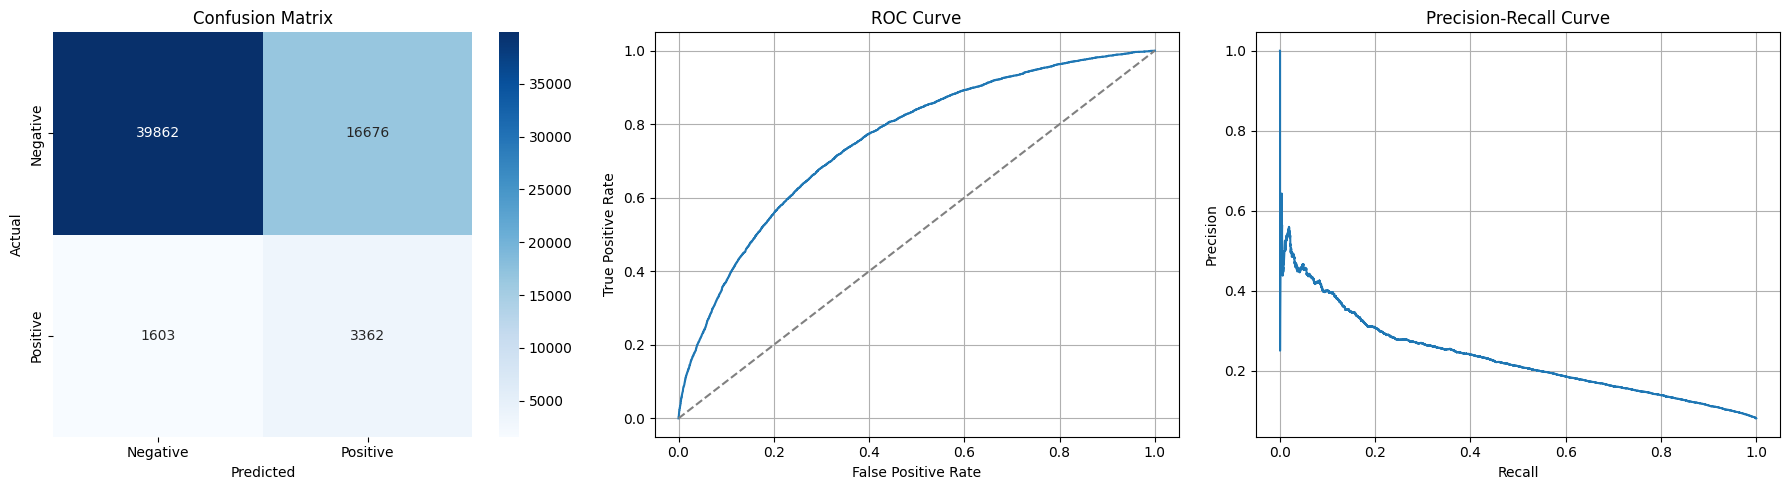

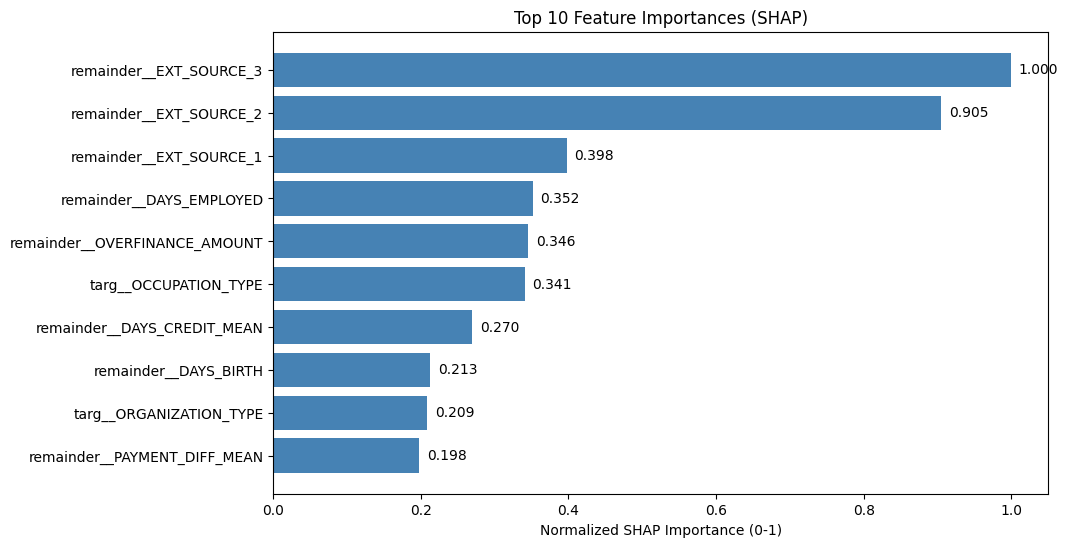

In [4]:
forest_pipeline, forest_data = evaluate_pipeline('random_forest', data)

### LightGBM


Best hyperparameters:
{'model__subsample': 0.9, 'model__reg_lambda': 1, 'model__reg_alpha': 5, 'model__num_leaves': 20, 'model__n_estimators': 450, 'model__min_split_gain': 0.5, 'model__min_child_samples': 50, 'model__max_depth': 5, 'model__learning_rate': 0.06, 'model__colsample_bytree': 1, 'model__class_weight': 'balanced', 'model__bagging_freq': 1}

lightgbm - CV METRICS (mean ± std):
Accuracy: 72.97% ± 0.24%
F1: 29.12% ± 0.11%
Precision: 18.47% ± 0.09%
Recall: 68.75% ± 0.52%
Roc_auc: 78.16% ± 0.21%

lightgbm - VAL METRICS:
Accuracy: 73.15%
F1 Score: 29.53%
Precision: 18.73%
Recall: 69.69%
ROC AUC: 78.52%


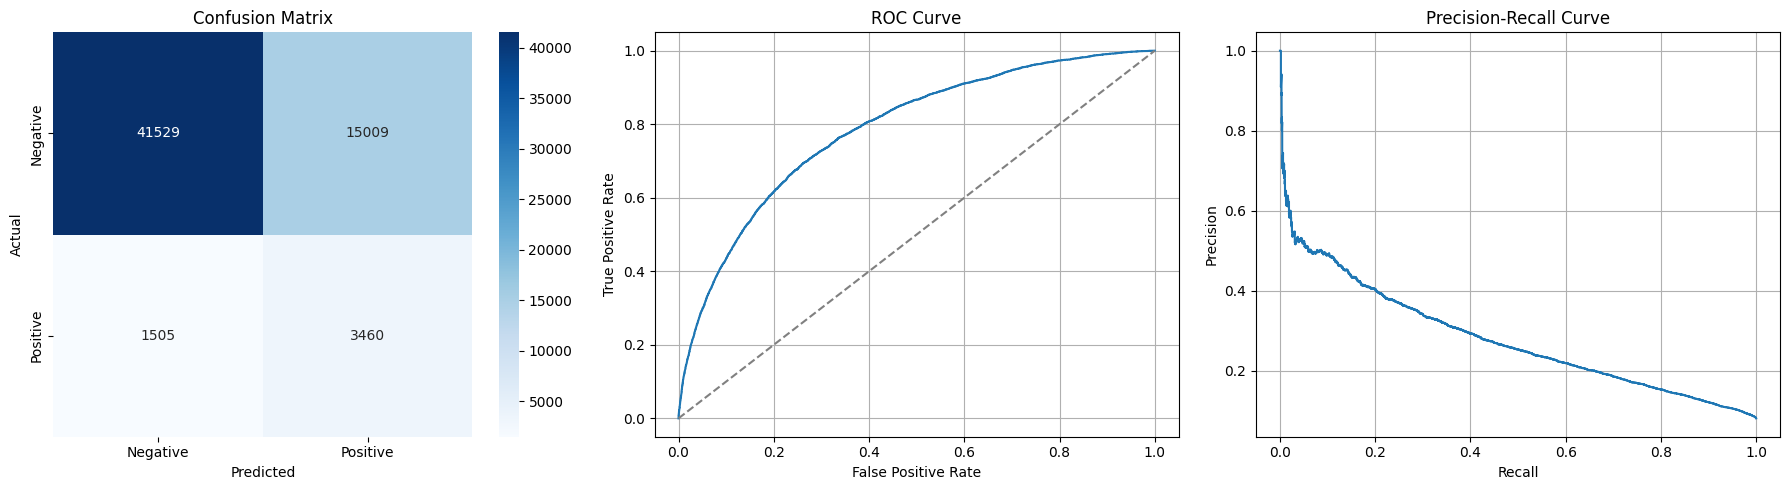

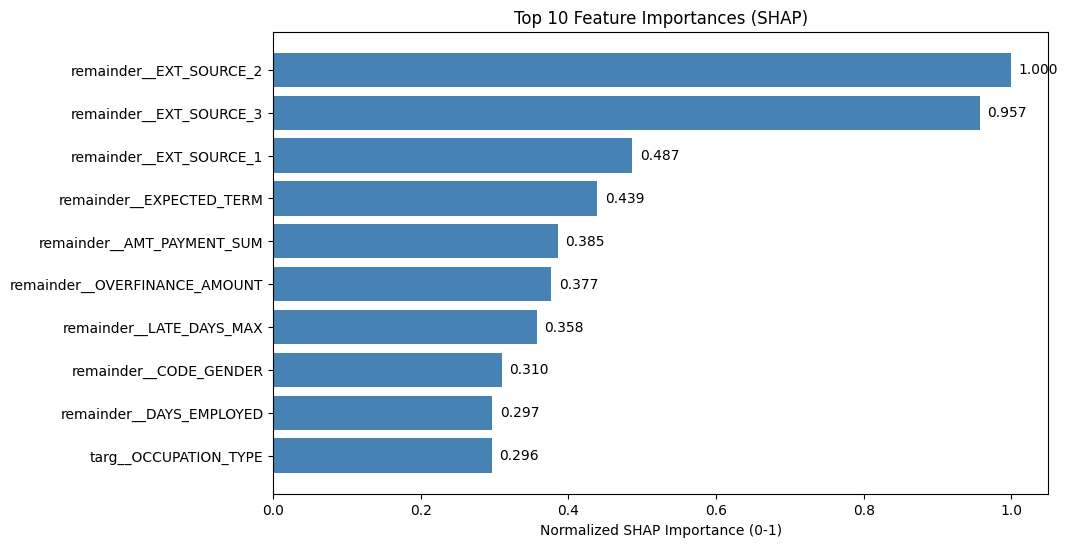

In [5]:
light_pipeline, light_data = evaluate_pipeline('lightgbm', data)

# Analysis

In [9]:
# Precomputed metric results from evaluation
model_data = {
    'dummy_classifier': dummy_data,
    'logistic_regression': logistic_data,
    'random_forest': forest_data,
    'lightgbm': light_data
}

fitted_pipelines = {
    'dummy_classifier': dummy_pipeline,
    'logistic_regression': logistic_pipeline,
    'random_forest': forest_pipeline,
    'lightgbm': light_pipeline
}

metrics_to_display = {
    'Accuracy': '{:.2%}',
    'F1': '{:.2%}',
    'Precision': '{:.2%}',
    'Recall': '{:.2%}',
    'Roc_auc': '{:.2%}'
}
metrics_to_display = {primary_metric.capitalize(): metrics_to_display[primary_metric.capitalize(
)], **{k: v for k, v in metrics_to_display.items() if k != primary_metric.capitalize()}}

best_model, best_pipeline = summarize_model_results(
    model_data,
    primary_metric,
    metrics_to_display,
    fitted_pipelines
)

if not model_configs.get(best_model, {}).get('baseline', False):
    joblib.dump(best_pipeline, SAVE_PATH / f"{best_model}_pipeline.pkl")

Worst model by Roc_auc: dummy_classifier with a score of 50.32%
Best model by Roc_auc: lightgbm with a score of 78.16%


,Roc_auc,Accuracy,F1,Precision,Recall
lightgbm,78.16%,72.97%,29.12%,18.47%,68.75%
random_forest,75.16%,70.21%,26.61%,16.61%,66.90%
logistic_regression,63.21%,70.62%,19.60%,12.58%,44.36%
dummy_classifier,50.32%,72.80%,12.25%,8.28%,23.52%


Overall, lightgbm performed the best for the area under the ROC curve. It also performed very well on the other metrics, leading in all of them as well. Dummy classifier performed well as an accuracy baseline, scoring 72.80%, only 0.17% below lightgbm. That demonstrates how accuracy alone is misleading, especially in an inbalanced situation like this. Random forest did similarly to lightgbm in all metrics, training behind by a few percentage points.

In [25]:
X_train_preprocessed, _ = prepare_data(X_train, None, y_train)

# Rename columns for analysis
X_train_preprocessed.columns = X_train_preprocessed.columns.str.replace(
    "remainder__", "pass__", regex=False)

# Get predictions on training data
y_train_pred = best_pipeline.predict(X_train)

# Only get wrong predictions
y_train = y_train.reset_index(drop=True)
wrong_mask = y_train_pred != y_train
X_train_preprocessed = X_train_preprocessed.reset_index(drop=True)
wrong_examples = X_train_preprocessed.loc[wrong_mask]

label_map = {
    0: f"Not {label}",
    1: label.capitalize()
}

display = wrong_examples.copy()
display['Actual'] = y_train[wrong_mask].values
display['Predicted'] = y_train_pred[wrong_mask]

display['Actual'] = display['Actual'].map(label_map)
display['Predicted'] = display['Predicted'].map(label_map)

# Show a few wrong examples
display.sample(5, random_state=42)

,targ__OCCUPATION_TYPE,targ__ORGANIZATION_TYPE,targ__NAME_HOUSING_TYPE,targ__TOP_GOODS_CATEGORY,pass__CODE_GENDER,pass__FLAG_OWN_CAR,pass__AMT_INCOME_TOTAL,pass__AMT_CREDIT,pass__AMT_ANNUITY,pass__REGION_POPULATION_RELATIVE,pass__DAYS_BIRTH,pass__DAYS_EMPLOYED,pass__DAYS_REGISTRATION,pass__DAYS_ID_PUBLISH,pass__FLAG_WORK_PHONE,pass__CNT_FAM_MEMBERS,pass__REGION_RATING_CLIENT,pass__EXT_SOURCE_1,pass__EXT_SOURCE_2,pass__EXT_SOURCE_3,pass__DAYS_LAST_PHONE_CHANGE,pass__AMT_REQ_CREDIT_BUREAU_YEAR,pass__FLAG_DOCUMENT_3,pass__HOUR_APPR_PROCESS_START,pass__OWN_CAR_AGE,pass__APARTMENTS_AVG,pass__CREDIT_CLOSED_CNT_SUM,pass__CREDIT_ACTIVE_CNT_SUM,pass__DAYS_CREDIT_MEAN,pass__DAYS_CREDIT_ENDDATE_MEAN,pass__AMT_CREDIT_SUM_MEAN,pass__AMT_CREDIT_SUM_DEBT_MEAN,pass__AMT_CREDIT_SUM_DEBT_STD,pass__AMT_CREDIT_SUM_LIMIT_MEAN,pass__DAYS_CREDIT_UPDATE_MIN,pass__DAYS_ENDDATE_FACT_MEAN,pass__CREDIT_TYPE_CONSUMER_SUM,pass__CREDIT_TYPE_NOT_CONSUMER_SUM,pass__OLDEST_BALANCE_MONTH_MIN,pass__AMT_DOWN_PAYMENT_MEAN,pass__CNT_CONTSTATUS_APPROVED_SUM,pass__CNT_CONTSTATUS_REFUSED_SUM,pass__CNT_CONTSTATUS_CANCELED_SUM,pass__YIELD_SCORE_MEAN,pass__CNT_PAYMENT_MEAN,pass__CNT_PAYMENT_STD,pass__AMT_APPLICATION_MEAN,pass__APPLICATION_RATIO_MEAN,pass__RATE_DOWN_PAYMENT_MEAN,pass__DAYS_FIRST_DUE_MEAN,pass__AMT_CREDIT_LIMIT_ACTUAL_MEAN,pass__AMT_BALANCE_MEAN,pass__CNT_INSTALMENT_MATURE_CUM_MAX,pass__BALANCE_LIMIT_RATIO_MEAN,pass__PAYMENT_DIFF_MEAN,pass__PAYMENT_DIFF_STD,pass__LATE_DAYS_MEAN,pass__LATE_DAYS_MAX,pass__AMT_PAYMENT_SUM,pass__SK_DPD_MEAN,pass__SK_DPD_DEF_MAX,pass__MONTHS_BALANCE_MIN,pass__MONTHS_BALANCE_MAX,pass__MONTHS_BALANCE_COUNT,pass__OVERFINANCE_AMOUNT,pass__NAME_FAMILY_STATUS_Married,pass__EXPECTED_TERM,pass__EST_TOTAL_REPAID,pass__PROFIT_AMOUNT,pass__INCOME_PER_YEAR_EMPLOYED,Actual,Predicted
95644,0.1126,0.1575,0.1172,0.0927,1,0,157500.0000,270000.0000,13500.0000,0.0031,-7915,-960.0000,-2785.0000,-97,0,2,3,0.0706,0.2830,0.3047,-628,0.0000,0,15,-1,0.0000,0.0000,1.0000,-23.0000,31060.0000,134932.5000,134932.5000,254071.3740,5871.8007,-17.0000,-970.2490,0,1,1.0000,5647.5000,1.0000,0.0000,0.0000,4.0000,12.0000,10.0970,56452.5000,1.0050,0.0995,-597.0000,-1.0000,-1.0000,-1.0000,-1.0000,0.0000,0.0000,-13.5833,-10.0000,81952.1550,0.0000,0.0000,-21.0000,-9.0000,13.0000,1.0000,True,20.0000,162000.0000,1080000.0000,34883.1917,Not TARGET,Target
10828,0.1809,0.0749,0.0779,0.0896,0,0,54000.0000,284400.0000,13963.5000,0.0228,-11307,-216.0000,-4019.0000,-3958,0,1,2,0.1744,0.5648,-1.0000,-333,1.8975,1,16,-1,0.0000,0.0000,0.0000,-1083.3234,653.1013,377582.1126,160631.5488,254071.3740,5871.8007,-1182.0647,-970.2490,4,1,1.0000,2587.5000,2.0000,2.0000,2.0000,2.6667,8.5000,3.0000,30734.2500,0.9613,0.1061,-2216.0000,-1.0000,-1.0000,-1.0000,-1.0000,-152.5813,536.0345,-6.6957,9.0000,63166.9500,0.0000,0.0000,-76.0000,-62.0000,22.0000,1.2640,False,20.3674,118689.7500,758400.0000,11959.9515,Not TARGET,Target
149008,0.0960,0.1021,0.0779,0.0479,1,0,67500.0000,754740.0000,24345.0000,0.0145,-13767,-1589.0000,-1769.0000,-4316,0,2,2,-1.0000,0.3420,0.3673,-926,0.0000,1,8,-1,0.0000,4.0000,3.0000,-713.7143,8579.0000,115370.3571,77340.8571,127443.3791,0.0000,-859.0000,-605.2500,5,2,-43.0000,8554.5000,1.0000,0.0000,0.0000,2.0000,10.0000,10.0970,65218.5000,1.1894,0.1496,-841.0000,-1.0000,-1.0000,-1.0000,-1.0000,0.0000,0.0000,-49.8750,-4.0000,79591.6350,0.0000,0.0000,-31.0000,-21.0000,11.0000,1.1980,True,31.0018,243450.0000,1509480.0000,14949.9393,Not TARGET,Target
88173,0.1052,0.0927,0.1234,0.0896,0,1,247500.0000,450000.0000,30073.5000,0.0226,-16107,-122.0000,-4957.0000,-3757,1,2,2,0.3685,0.6494,-1.0000,-2354,1.8975,1,15,6,0.1113,0.0000,0.0000,-1083.3234,653.1013,377582.1126,160631.5488,254071.3740,5871.8007,-1182.0647,-970.2490,4,1,1.0000,0.0000,5.0000,1.0000,2.0000,1.8750,22.0000,17.2511,198562.5000,0.8293,0.0000,-2461.0000,120170.4545,15240.2753,15.0000,0.1226,0.0000,0.0000,-17.3488,0.0000,503967.5550,0.0000,0.0000,-96.0000,-68.0000,18.0000,1.0000,True,14.9633,661617.0000,843750.0000,5

While the examples for incorrect predictions are taken from a '.sample', they all share the same case: they were predicted to default but did not. This makes sense, as lightgbm's confusion matrix has many false positives. Additionally, many of their features are very similar, such as them all having missing values for `SK_DPD_DEF_MAX` and `SK_DPD_MEAN`, signifying that they all have no entries in POS_CASH_balance.csv. Overall, the examples are likely hard-to-predict edge cases.


SHAP explanation: (Pred: Target, Actual: Not TARGET)


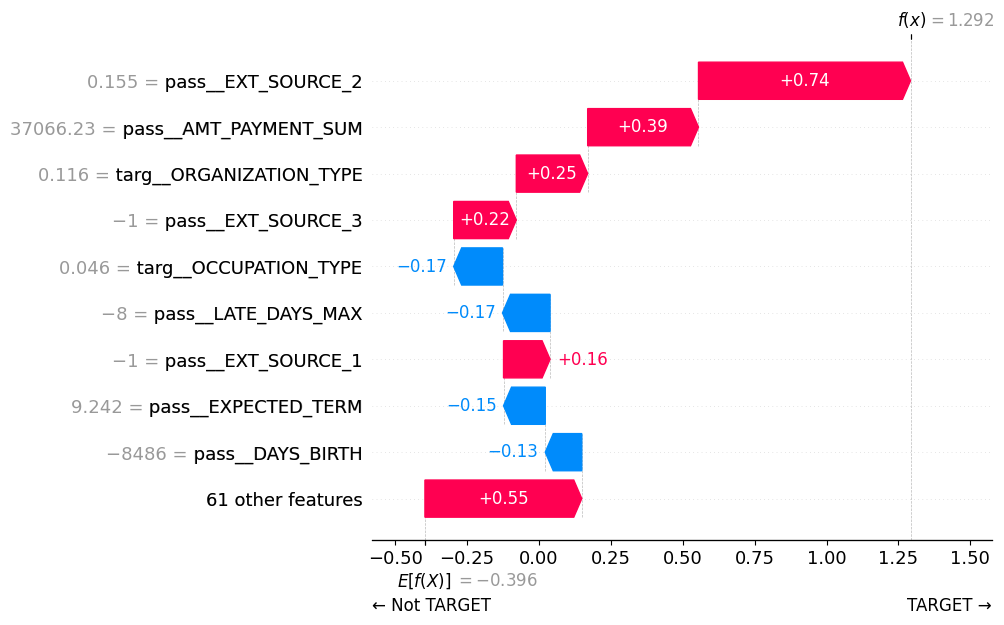

In [12]:
wrong_row_idx = wrong_examples.index[0]

row = display.loc[wrong_row_idx]
actual_value = row['Actual']
predicted_value = row['Predicted']

model = best_pipeline.named_steps['model']

shap_input = X_train_preprocessed.loc[[wrong_row_idx]]
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(shap_input)
shap_values_instance = shap_values[1]
shap_values_instance = shap.Explanation(
    # Flatten the values to 1D to match the shape
    values=shap_values_instance[0].flatten(),
    # Base value for the positive class
    base_values=explainer.expected_value[1],
    # Flatten the input values to match the expected shape
    data=shap_input.values.flatten(),
    feature_names=X_train_preprocessed.columns.tolist()
)

print(f"\nSHAP explanation: (Pred: {predicted_value}, Actual: {actual_value})")

shap.plots.waterfall(shap_values_instance, show=False)

ax = plt.gca()

# Add custom labels on the left and right side of the plot
# Left label
ax.annotate(f"← Not {label}", xy=(0, -.15), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='bottom', fontsize=12, color='black')

# Right label
ax.annotate(f"{label} →", xy=(1, -.15), xycoords='axes fraction',
            horizontalalignment='right', verticalalignment='bottom', fontsize=12, color='black')

plt.show()

Although the model predicted that this applicant would default with high confidence, the applicant actually did not default. Many of the high SHAP importance features led to this decision, `EXT_SOURCE_2` and `ORGANIZATION_TYPE` being two of them. Since `EXT_SOURCE_2`'s value was quite low (with 0 being high risk), it makes sense that it was the feature with the highest decision-making power.